In [339]:
from time import time


import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
import time

import torch
import sklearn.datasets
import sklearn.preprocessing
import sklearn.model_selection
import numpy as np
import math
import matplotlib.pyplot as plt

from torchvision.datasets import MNIST
from torchvision.datasets import FashionMNIST as FMNIST
from torchvision.datasets import EMNIST
import torchvision.transforms as transforms

import onlinehd as Onlinehd

import tensorflow as tf
import random as r
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, Adadelta, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout, Flatten, Activation, BatchNormalization


## Data Load
Output: df frame with all data

In [340]:
path="../../Data/"
attacks_types = {
    'normal': 'normal','back': 'dos','buffer_overflow': 'u2r','ftp_write': 'r2l','guess_passwd': 'r2l',
'imap': 'r2l','ipsweep': 'probe','land': 'dos','loadmodule': 'u2r','multihop': 'r2l','neptune': 'dos',
'nmap': 'probe','perl': 'u2r','phf': 'r2l','pod': 'dos','portsweep': 'probe','rootkit': 'u2r','satan': 'probe',
'smurf': 'dos','spy': 'r2l','teardrop': 'dos','warezclient': 'r2l','warezmaster': 'r2l',
}
cols ="""duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,
urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,
num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,
count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,
diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,
dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,
dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate"""
  
columns =[]
for c in cols.split(','):
    if(c.strip()):
       columns.append(c.strip())
print(len(columns))
columns.append('target')
print(len(columns))

attack_categories=["dos","u2r","r2l",'probe','normal']
df = pd.read_csv(path+"kddcup.data_10_percent.gz", names = columns)
df['Attack Type'] = df.target.apply(lambda r:attacks_types[r[:-1]])
del df['target']
df.head()



41
42


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,Attack Type
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal


## Initial Preprocessing
Output: X and Y numpy arrays

In [341]:
num_cols = df._get_numeric_data().columns
  
cate_cols = list(set(df.columns)-set(num_cols))
cate_cols.remove('Attack Type')
def getuniquevalues(columnname):
    values={}
    i=0
    for entry in df[columnname]:
        if entry not in values:
            values[entry]=i
            i+=1
    return values
for col in cate_cols:
    df[col]=df[col].map(getuniquevalues(col))
data=df.to_numpy()
Y=df['Attack Type'].map(getuniquevalues('Attack Type'))
Y=Y.to_numpy()
X=data[:,:-1]
print(Y.shape)
print(X.shape)
print(getuniquevalues('Attack Type'))

(494021,)
(494021, 41)
{'normal': 0, 'u2r': 1, 'dos': 2, 'r2l': 3, 'probe': 4}


## Conversion to Torch
also scaling

In [203]:
# def load(x,y):
#     x, x_test, y, y_test = sklearn.model_selection.train_test_split(x, y)
#     scaler = sklearn.preprocessing.Normalizer().fit(x)
#     x = scaler.transform(x)
#     x_test = scaler.transform(x_test)

#     # changes data to pytorch's tensors
#     x = torch.from_numpy(x).float()
#     y = torch.from_numpy(y).long()
#     x_test = torch.from_numpy(x_test).float()
#     y_test = torch.from_numpy(y_test).long()
#     return x, x_test, y, y_test, scaler

In [234]:
def normalized(x,y):
    x, x_test, y, y_test = sklearn.model_selection.train_test_split(x, y, shuffle=True)
    scaler = sklearn.preprocessing.Normalizer().fit(x)
    x = scaler.transform(x)
    x_test = scaler.transform(x_test)

    # changes data to pytorch's tensors
    x = torch.from_numpy(x).float()
    y = torch.from_numpy(y).long()
    x_test = torch.from_numpy(x_test).float()
    y_test = torch.from_numpy(y_test).long()
    return x, x_test, y, y_test, scaler
def nonnormalized(x,y):
    x,x_test,y,y_test = sklearn.model_selection.train_test_split(x, y, shuffle=True)
    x=x.astype(np.float64)
    x_test=x_test.astype(np.float64)
    x=torch.from_numpy(x).float()
    x_test=torch.from_numpy(x_test).float()
    y=torch.from_numpy(y)
    y_test = torch.from_numpy(y_test)
    return x, x_test, y, y_test


In [236]:
xtrain, x_test, ytrain, y_test,scaler= normalized(X,Y)

## OnlineHD

In [309]:
model = Onlinehd.OnlineHD(len(df['Attack Type'].unique()), df.shape[1]-1, dim=1000)

In [310]:
model = model.fit(xtrain,ytrain, bootstrap=1.0, lr=.1, epochs=20, one_pass_fit=True)#0.035

In [311]:
for i in range (0,len(df['Attack Type'].unique())):
    yhat= model(x_test[y_test==i])
    acc = (yhat==i).float().mean()
    print('class '+str(i)+' accuracy: ' +str(acc))
    print('points: '+ str(len(yhat)))


/Users/bobbymissirian/Files/Research/Cybersecurity/onlinehd/encoder.py:61: UserWarning: An output with one or more elements was resized since it had shape [245, 1000], which does not match the required output shape [189, 1000].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:23.)
  torch.matmul(x[i:i+bsize], self.basis.T, out=temp)


class 0 accuracy: tensor(0.9585)
points: 24444
class 1 accuracy: tensor(0.3571)
points: 14
class 2 accuracy: tensor(0.9928)
points: 97760
class 3 accuracy: tensor(0.8671)
points: 286
class 4 accuracy: tensor(0.9032)
points: 1002


/Users/bobbymissirian/Files/Research/Cybersecurity/onlinehd/encoder.py:61: UserWarning: An output with one or more elements was resized since it had shape [978, 1000], which does not match the required output shape [938, 1000].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:23.)
  torch.matmul(x[i:i+bsize], self.basis.T, out=temp)
/Users/bobbymissirian/Files/Research/Cybersecurity/onlinehd/encoder.py:61: UserWarning: An output with one or more elements was resized since it had shape [3, 1000], which does not match the required output shape [1, 1000].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with

In [312]:
yhat = model(xtrain)
yhat_test = model(x_test)
acc = (ytrain == yhat).float().mean()
acc_test = (y_test == yhat_test).float().mean()
print(f'{acc = :6f}')
print(f'{acc_test = :6f}')

acc = 0.984727
acc_test = 0.984932


/Users/bobbymissirian/Files/Research/Cybersecurity/onlinehd/encoder.py:61: UserWarning: An output with one or more elements was resized since it had shape [1236, 1000], which does not match the required output shape [1142, 1000].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:23.)
  torch.matmul(x[i:i+bsize], self.basis.T, out=temp)


## MLP

In [313]:
print(type(X))

<class 'numpy.ndarray'>


In [322]:
model = Sequential()
model.add(Dense(41, activation='relu', input_shape=(41,)))
model.add(Dense(20, activation='relu', input_shape=(41,)))
model.add(Dense(5, activation="softmax"))


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 41)                1722      
_________________________________________________________________
dense_18 (Dense)             (None, 20)                840       
_________________________________________________________________
dense_19 (Dense)             (None, 5)                 105       
Total params: 2,667
Trainable params: 2,667
Non-trainable params: 0
_________________________________________________________________
(370515, 41) (370515, 5)
Epoch 1/30
30/30 [==============================] - 1s 12ms/step - loss: 1.1364 - accuracy: 0.8035 - val_loss: 0.7776 - val_accuracy: 0.8054
Epoch 2/30
30/30 [==============================] - 0s 6ms/step - loss: 0.5653 - accuracy: 0.8678 - val_loss: 0.3957 - val_accuracy: 0.9014
Epoch 3/30
30/30 [==============================] - 0s 6ms/step - loss: 0.31

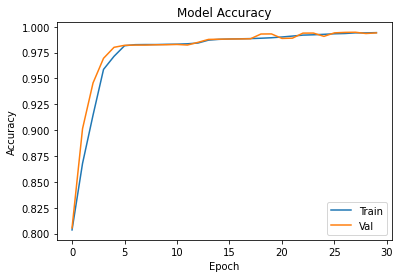

0.9943153262138367

In [323]:
batchsize=10000
epochs=30
learningrate=.001
def plot_accuracies(hist):
    print("Final Accuracy: " + str(hist.history['accuracy'][len(hist.history['accuracy'])-1]))
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    if len(hist.history['accuracy'])==1:
        plt.plot([0], [hist.history['accuracy'][0]], marker='o', markersize=3, color="blue")
        plt.plot([0], [hist.history['val_accuracy'][0]], marker='o', markersize=3, color="orange")

    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()
def runTraining(model, x_train, y_train, batchSize, epochs, learningRate):
  opt = RMSprop(learning_rate= learningRate)
  model.compile(optimizer = opt, loss= 'categorical_crossentropy', metrics = ['accuracy'])
  model.summary()
  print(np.shape(x_train), np.shape(y_train))
  history = model.fit(x_train, y_train,
                    batch_size = batchSize,
                    epochs = epochs, validation_split = .2, verbose = 1)
  plot_accuracies(history)
  return history.history['accuracy'][len(history.history['accuracy'])-1]
ohe = sklearn.preprocessing.OneHotEncoder()
transformed = ohe.fit_transform(np.expand_dims(ytrain.numpy(),1))
runTraining(model, xtrain.numpy(), transformed.toarray(), batchsize, epochs, learningrate)

In [324]:
yhat=model(x_test.numpy())
yhat=np.array([row.numpy().argmax() for row in yhat])
print(yhat)
# acc = (yhat == ohe.fit_transform(np.expand_dims(y_test.numpy(),1)).toarray()).float().mean()
# print(acc)


[2 0 2 ... 2 2 0]


In [284]:
for i in range (0,len(df['Attack Type'].unique())):
    yhat= model(x_test.numpy()[y_test==i])
    yhat=np.array([row.numpy().argmax() for row in yhat])
    acc = (yhat==i).mean()
    print('class '+str(i)+' accuracy: ' +str(acc))
    print('points: '+ str(len(yhat)))

class 0 accuracy: 0.9968499427262314
points: 24444
class 1 accuracy: 0.0
points: 14
class 2 accuracy: 0.9985270049099836
points: 97760
class 3 accuracy: 0.0
points: 286
class 4 accuracy: 0.8293413173652695
points: 1002


## NeuralHD

In [325]:
import sklearn
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
import time
import sys
import math
import numpy as np
import random
import joblib
from tqdm import tqdm_notebook
import copy

import Config
import Dataloader as DL
import HD_basis as HDB
import HD_encoder as HDE
import HD_classifier as HDC

import matplotlib.pyplot as plt


In [289]:
def train(hdc, traindata, trainlabels, testdata, testlabels, param = Config.config, epochs = None):
    train_acc = []
    test_acc = []
    if epochs is not None:
        param["epochs"] = epochs
    #for i in tqdm_notebook(range(param["epochs"]), desc='epochs'):
    for i in range(param["epochs"]):
        train_acc.append(hdc.fit(traindata, trainlabels, param))
        test_acc.append(hdc.test(testdata, testlabels))
        # if len(train_acc) % 20 == 0:
        #     print("Train: %f \t \t Test: %f"%(train_acc[-1], test_acc[-1]))
        # if train_acc[-1] == 1:
        #     print("Training converged!") 
        #     print("Train: %f \t \t Test: %f"%(train_acc[-1], test_acc[-1]))
        #     break
    return np.asarray(train_acc), np.asarray(test_acc), i

In [334]:
def train_neural_ed(traindata, trainlabels, testdata, testlabels,
                   D, # initial baseline
                   eDs,  # list of effective dimensions to reach 
                   percentDrop, # drop/regen rate 
                   iter_per_update, # # iterations per regen  
                   param):

    param["D"] = D
    
    # Initialize basis & classifier
    hdb = HDB.HD_basis(HDB.Generator.Vanilla, param)
    basis = hdb.getBasis()
    param = hdb.getParam()
    hde = HDE.HD_encoder(basis)
    trainencoded = hde.encodeData(traindata)
    testencoded = hde.encodeData(testdata)
    # Initialize classifier
    train_accs = []
    test_accs = []
    hdc = HDC.HD_classifier(param["D"], param["nClasses"], 0)

    # Prepare setting for train
    amountDrop = int(percentDrop * hdc.D)
    regenTimes = [ math.ceil((eD-D)/amountDrop) for eD in eDs]
    print("Updating times:", regenTimes)

    early_stopping_steps = 1000 # earlystopping is "turned off"

    #es_count = 0
    max_test = 0
    best = None
    best_idx = 0
    
    # Checkpoints
    checkpoints = []

    for i in range(max(regenTimes)+1): # For each eDs to reach, will checkpoints

        # Do the train 
        for j in range(iter_per_update):
            train_acc = 100 * hdc.fit(trainencoded, trainlabels, param)
            test_acc = 100 * hdc.test(testencoded, testlabels)
            train_accs.append(train_acc)
            test_accs.append(test_acc)
            print("Train: %.2f \t \t Test: %.2f"%(train_acc, test_acc))
            if train_acc == 100:
                break
         
        if train_acc == 100:
            print("Train converged! taking snippit in checkpoints")
            hdb_ck = copy.deepcopy(hdb)
            hdc_ck = copy.deepcopy(hdc)
            _, post_test_accs, _ = train(hdc_ck, trainencoded, trainlabels, testencoded, testlabels, param, epochs = 50)
            checkpoints.append((i+1, (D + (i)*amountDrop), 
                                hdb_ck, hdc_ck, 
                                max(test_accs[-iter_per_update:]), max(post_test_accs)))

        if test_accs[-1] >= max_test:
            es_count = 0
            best = copy.deepcopy(hdc)
            best_idx = len(test_accs)
        else:
            es_count += 1
        if es_count > early_stopping_steps:
            print("Early stopping initiated, best stores the best hdc currently")
            break
        
        if i in regenTimes:
            print("Checkpoint made!")
            hdb_ck = copy.deepcopy(hdb)
            hdc_ck = copy.deepcopy(hdc)
            _, post_test_accs, _ = train(hdc_ck, trainencoded, trainlabels, testencoded, testlabels, param, epochs = 50)
            checkpoints.append((D, (D + (i)*amountDrop), 
                                None, None, #hdb_ck, hdc_ck, 
                                max(test_accs[-iter_per_update:]), max(post_test_accs)))
        
        # Do the regeneration
        var, orders = hdc.evaluateBasis()
        toDrop = orders[:amountDrop]
        toMask = orders[-amountDrop:]
        toDropVar = [var[i] for i in toDrop]
        print("Variances stats: max %.2f, min %.2f, mean %.2f"%(max(var),min(var),np.mean(var)))
        #print("Dropping first %f percent of ineffective basis, with stats: max %f, min %f, mean %f"\
        #      %(percentDrop, max(toDropVar),min(toDropVar),np.mean(toDropVar)))
        hdb.updateBasis(toDrop)
        hde.updateBasis(hdb.basis)
        trainencoded = hde.encodeData(traindata)
        testencoded = hde.encodeData(testdata)
        hdc.updateClasses()
        
    return hdc


In [295]:
print(type(xtrain))

<class 'torch.Tensor'>


In [335]:
Ds = [2000, 3000]
percentDrops = [0.1]
iter_per_updates = [3]
param = Config.config
param["nFeatures"] = xtrain.shape[1]
param["nClasses"] = len(df['Attack Type'].unique())
#Ds = [200, 500, 750, 1000, 1500, 2000, 2500, 3000, 4000]
#percentDrops = [0.05]
#iter_per_updates = [1, 2, 3, 4]


hdc=None
for i, D in enumerate(Ds[:-1]):
    eDs = Ds[i+1:i+7]
    for percentDrop in percentDrops:
        for iter_per_update in iter_per_updates:
            print("Current config:", D, percentDrop, iter_per_update)
            hdc = train_neural_ed(xtrain.numpy(), ytrain.numpy(), x_test.numpy(), y_test.numpy(),
                   D, # initial baseline
                   eDs,  # list of effective dimensions to reach 
                   percentDrop, # drop/regen rate 
                   iter_per_update, # # iterations per regen  
                   param)

Current config: 2000 0.1 3
Updating times: [5]
Train: 98.38 	 	 Test: 99.23
Train: 98.63 	 	 Test: 98.94
Train: 98.71 	 	 Test: 97.84
Variances stats: max 0.02, min 0.00, mean 0.00
Updating basis......
Train: 98.54 	 	 Test: 98.83
Train: 98.74 	 	 Test: 98.99
Train: 98.75 	 	 Test: 99.26
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 98.55 	 	 Test: 99.34
Train: 98.74 	 	 Test: 99.07
Train: 98.78 	 	 Test: 98.75
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 98.58 	 	 Test: 97.82
Train: 98.75 	 	 Test: 98.00
Train: 98.75 	 	 Test: 98.85
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 98.57 	 	 Test: 98.06
Train: 98.72 	 	 Test: 98.89
Train: 98.80 	 	 Test: 98.70
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 98.57 	 	 Test: 97.90
Train: 98.76 	 	 Test: 98.29
Train: 98.80 	 	 Test: 98.91
Checkpoint made!
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......


In [338]:
for i in range (0,len(df['Attack Type'].unique())):
    yhat= hdc(x_test.numpy()[y_test==i])
    yhat=np.array([row.numpy().argmax() for row in yhat])
    acc = (yhat==i).mean()
    print('class '+str(i)+' accuracy: ' +str(acc))
    print('points: '+ str(len(yhat)))

TypeError: 'HD_classifier' object is not callable

In [336]:
hdc

In [327]:
checkpoints

[(2000, 3000, None, None, 98.93284536783638, 0.9964617103622496)]

## Extras

In [179]:

Y=data[:,df.shape[1]-1]

In [180]:
attack_types

['dos', 'u2r', 'r2l', 'probe', 'normal']

In [181]:
attack_count={}
for attack_type in attack_categories:
    attack_count[attack_type]=X[Y==attack_type].shape
attack_count

{'dos': (391458, 41),
 'u2r': (52, 41),
 'r2l': (1126, 41),
 'probe': (4107, 41),
 'normal': (97278, 41)}

In [182]:
X=X.astype(np.float64)
X=torch.from_numpy(X).float()
Yspecial=torch.from_numpy(Yspecial)

In [188]:
def load(x,y):
    x, x_test, y, y_test = sklearn.model_selection.train_test_split(x, y)
    scaler = sklearn.preprocessing.Normalizer().fit(x)
    x = scaler.transform(x)
    x_test = scaler.transform(x_test)

    # changes data to pytorch's tensors
    x = torch.from_numpy(x).float()
    y = torch.from_numpy(y).long()
    x_test = torch.from_numpy(x_test).float()
    y_test = torch.from_numpy(y_test).long()
    return x, x_test, y, y_test, scaler

In [191]:
x,xtest,y,ytest,scaler=load(X,Yspecial)

TypeError: expected np.ndarray (got Tensor)

In [189]:


print('Training...')
# t = time()
# shape=list(X.shape)
# shape.append(1)
# print(shape)
# X=X.reshape(shape)

model = model.fit(X, Yspecial, bootstrap=1.0, lr=0.035, epochs=20)

# t = time() - t

Training...


/Users/bobbymissirian/Files/Research/Cybersecurity/onlinehd/encoder.py:61: UserWarning: An output with one or more elements was resized since it had shape [4941, 10000], which does not match the required output shape [4862, 10000].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:23.)
  torch.matmul(x[i:i+bsize], self.basis.T, out=temp)


In [343]:
type(xtrain.numpy())

numpy.ndarray